In [1]:
%matplotlib inline

In [2]:
%run notebook_setup
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

theano version: 1.0.4
pymc3 version: 3.6
exoplanet version: 0.1.5


In [3]:
toi_num = 125

In [4]:
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic]
periods = np.array(tois["Period (days)"], dtype=float)
epochs = np.array(tois["Epoch (BJD)"], dtype=float)
depths = np.array(tois["Depth (ppm)"], dtype=float)

# Stellar properties
temp_eff = toi['Stellar Eff Temp (K)']
temp_eff_err = toi['Stellar Eff Temp (K) err']
log_g = toi['Stellar log(g) (cm/s^2)']
log_g_err = toi['Stellar log(g) (cm/s^2) err']
r_star = toi['Stellar Radius (R_Sun)']
r_star_err = toi['Stellar Radius (R_Sun) err']

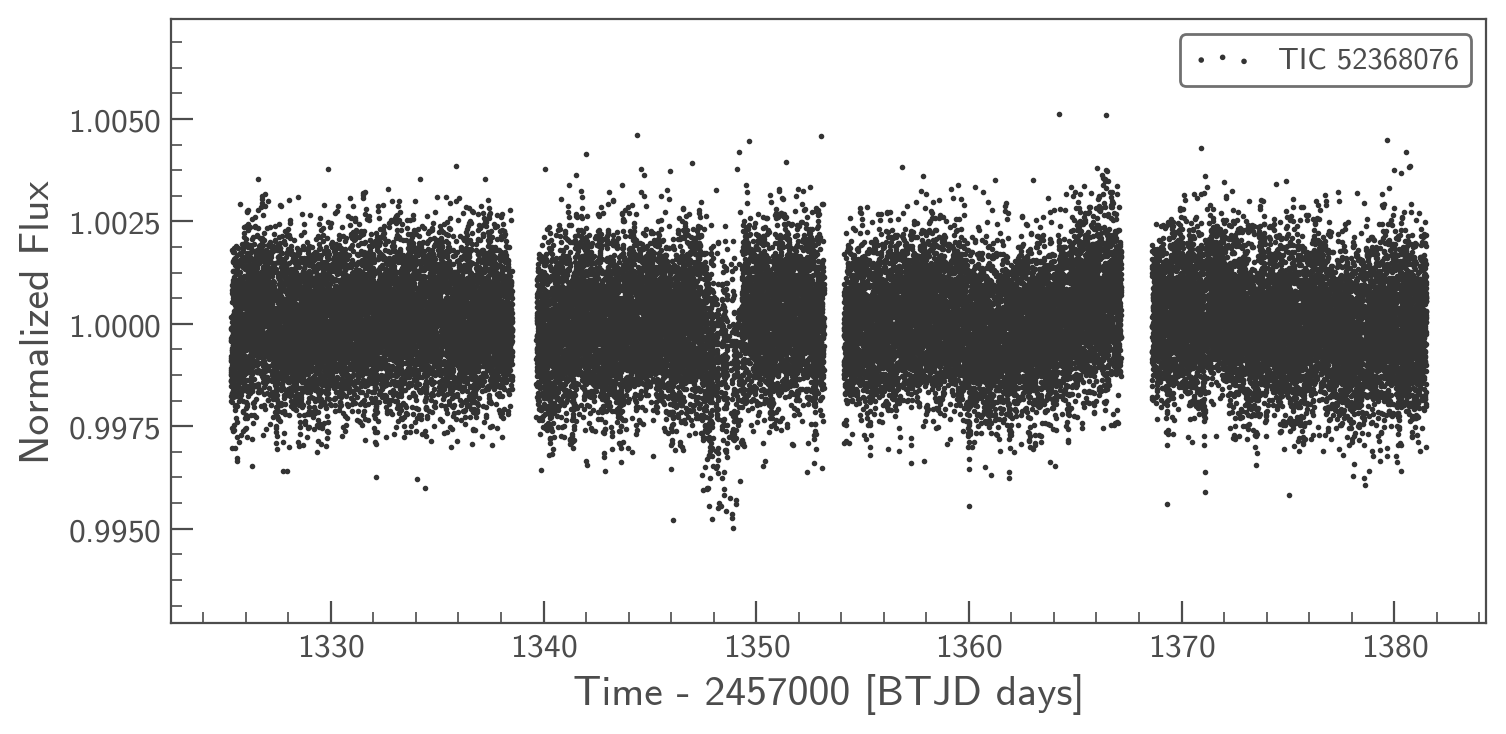

In [5]:
# Download fits files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()

def get_transit_mask(t, transit_time, period, duration=0.2):
    hp = 0.5*period
    return np.abs((t-transit_time+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF
lc_collection = []
for tpf in tpf_collection:
    mask = np.ones_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask &= get_transit_mask(tpf.time, epochs[i], periods[i])
    pld = tpf.to_corrector('pld')
    lc = pld.correct(cadence_mask=~mask, use_gp=False)
    lc_collection.append(lc)

# Normalize and stitch
lc = lc_collection[0].normalize()
if len(lc_collection) > 1:
    lc = lc.append([next_lc.normalize() for next_lc in lc_collection[1:]])
lc = lc.remove_outliers()
    
lc.scatter()

In [6]:
import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        
    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline flux
        mean = pm.Normal("mean", mu=0.0, sd=10.0)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=0.5,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(model.y)), sd=10)
        logw0 = pm.Normal("logw0", mu=np.log(2*np.pi/10), sd=10)

        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower", mu=np.log(np.var(model.y)), sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        model.gp = xo.gp.GP(kernel, model.x, tt.exp(logs2)+model.yerr**2, J=2)
        pm.Potential("transit_obs", model.gp.log_likelihood(model.y - model.light_curve))
        model.gp_pred = model.gp.predict()

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.gp_pred + model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        print(ntot, mask.sum())
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

In [7]:
# periods = periods
t0s = epochs - 2457000
depths = depths * 1e-3

x = lc.time
y = (lc.flux - 1.0) * 1e3
yerr = lc.flux_err * 1e3

model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

optimizing logp for variables: ['mean', 'logs2']
message: Optimization terminated successfully.
logp: -59730.123368682514 -> -54972.55736348546
optimizing logp for variables: ['mean', 'rb_radiusimpact__']
message: Optimization terminated successfully.
logp: -54972.55736348546 -> -54926.386863420696
optimizing logp for variables: ['mean', 't0', 'logP']
message: Desired error not necessarily achieved due to precision loss.
logp: -54926.386863420696 -> -54925.76706711151
optimizing logp for variables: ['logpower', 'logs2']
message: Optimization terminated successfully.
logp: -54925.76706711151 -> -54903.186776625225
optimizing logp for variables: ['logw0']
message: Desired error not necessarily achieved due to precision loss.
logp: -54903.186776625225 -> -54887.09349985006
optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'mean']
message: Desired error not necessarily achieved due to precision loss.
logp: -54887.0934998500

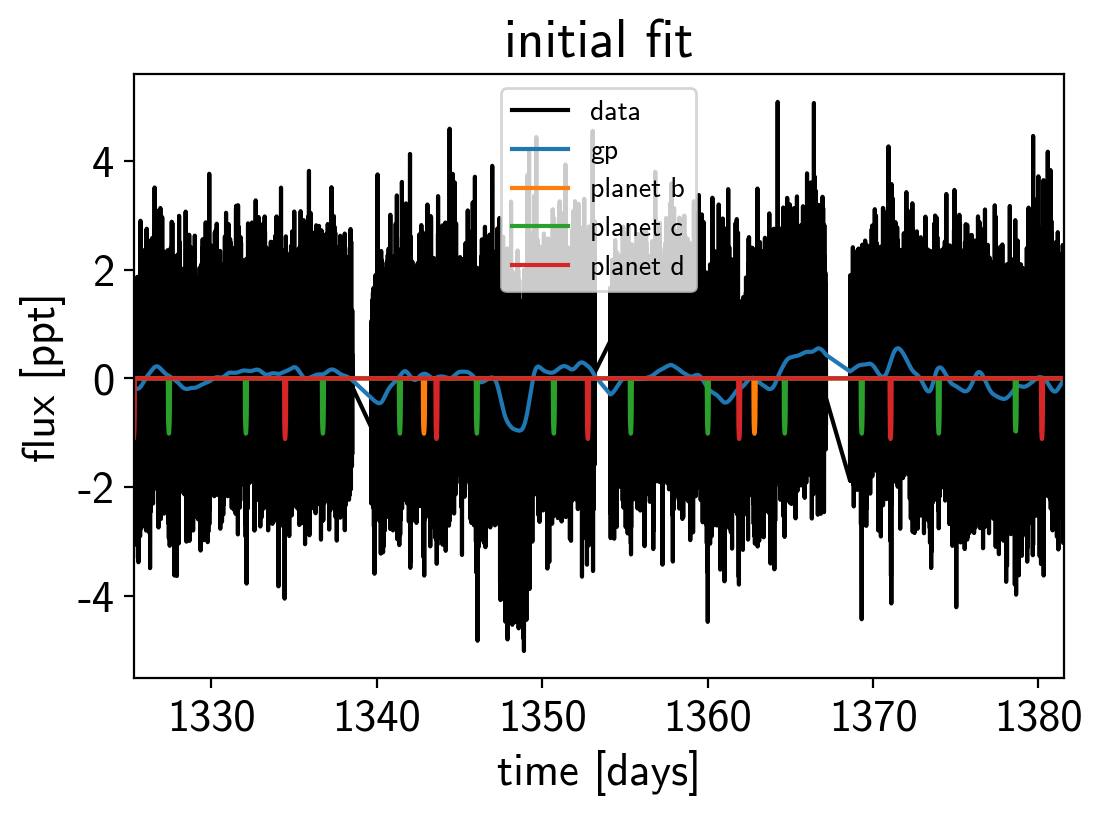

In [8]:
with model:
    mean = model.map_soln["mean"]
    gp_pred = xo.utils.eval_in_model(model.gp_pred, model.map_soln)
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
plt.plot(model.x, gp_pred, label="gp")
for n, l in enumerate("bcdefghijklmnopqrstuvwxyz"[:len(periods)]):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l))

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

In [9]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2)

Sampling 2 chains: 100%|██████████| 404/404 [03:10<00:00,  2.17draws/s]
The chain contains only diverging samples. The model is probably misspecified.
Sampling 2 chains:  87%|████████▋ | 3813/4404 [11:54<01:50,  5.34draws/s]


ValueError: Not enough samples to build a trace.

In [ ]:
with model:
    trace = sampler.sample(draws=1000, chains=2)

In [ ]:
import corner
samples = pm.trace_to_dataframe(trace)
for name in samples.columns:
    if "_" in name:
        samples[name.replace("_", " ")] = samples[name]
        del samples[name]

corner.corner(samples);

In [ ]:
pm.summary(trace)